# Entrega 2

In [3]:
import pandas as pd
import numpy as np

In [4]:
#cargamos el dataset
fulldata = pd.read_csv('shot_logs.csv')

#renombramos la columna, en la mayoria de los casos simplemente ponemos nombres en minuscula pero a otras
#hacemos los nombres mas descriptivos

renamed_columns = {'GAME_ID' : 'game_id', 'MATCHUP': 'matchup', 'LOCATION' : 'location', 'W' : 'game_result', 
                   'FINAL_MARGIN' : 'final_margin', 'SHOT_NUMBER': 'shot_number', 'PERIOD' : 'period', 
                   'GAME_CLOCK' : 'game_clock', 'SHOT_CLOCK' : 'shot_clock', 'DRIBBLES' : 'dribbles', 
                   'TOUCH_TIME' : 'touch_time', 'SHOT_DIST' : 'shot_dist', 'PTS_TYPE' : 'pts_type', 'SHOT_RESULT' : 'shot_result',
                   'CLOSEST_DEFENDER' : 'closest_defender', 'CLOSEST_DEFENDER_PLAYER_ID' : 'closest_defender_id', 
                  'CLOSE_DEF_DIST' : 'closest_defender_dist', 'FGM' : 'shot_result_id', 'PTS' : 'pts'}
fulldata.rename(columns=renamed_columns, inplace=True)

In [5]:
print('Cantidad de filas y columnas del dataset: ',fulldata.shape)

Cantidad de filas y columnas del dataset:  (128069, 21)


# Antes de entrenar los modelos acomodamos las variables
# Preprocesado y Feature engineering

#### Variables que no vamos a utilizar

In [6]:
dataprocesada = fulldata.drop(['pts'],axis=1) #ES DATA FUTURA, ES EL RESULTADO DEL TIRO
dataprocesada = dataprocesada.drop(['closest_defender_id'],axis=1) #Tenemos el nombre del jugador
dataprocesada = dataprocesada.drop(['player_id'],axis=1) #Tenemos el nombre del jugador
dataprocesada = dataprocesada.drop(['shot_result'],axis=1) #Tenemos el id del resultado del tiro
dataprocesada = dataprocesada.drop(['game_id'],axis=1) #No interesa el partido, puede inferir por el gran valor del id
dataprocesada = dataprocesada.drop(['game_result'],axis=1) #contiene data futura, no lo podemos utilizar
dataprocesada = dataprocesada.drop(['final_margin'],axis=1) #contiene data futura, no lo podemos utilizar
dataprocesada = dataprocesada.dropna(subset=['shot_clock']) #contiene valores nulls

In [7]:
print('Cantidad de datos luego de la primera limpieza: ', dataprocesada.shape)

Cantidad de datos luego de la primera limpieza:  (122502, 14)


In [8]:
dataprocesada = dataprocesada[dataprocesada['touch_time']>=0]
dataprocesada = dataprocesada[dataprocesada['shot_dist']<40]
dataprocesada = dataprocesada[dataprocesada['closest_defender_dist']<30]

In [9]:
print('Luego de la limpieza de outliers: ',dataprocesada.shape)

Luego de la limpieza de outliers:  (122152, 14)


In [10]:
#Pasar tiempo del partido a segundos
def tiempopartidoensegundos(tiempo_periodo):
    tiempo,periodo = tiempo_periodo
    minutos,segundos = [int(x) for x in tiempo.split(':')]
    # primero pasamos el tiempo del partido sin contar los suplementarios
    # Se fija en que cuarto está, dependiendo del cuarto le va a sumar tiempo al tiempo actual o no
    if periodo <= 4:
        cuartos_anteriores = (60*12)*(periodo-1)
        tiempo_del_cuarto = (60*12) - (minutos*60) - (segundos)
        return cuartos_anteriores + tiempo_del_cuarto
    # suplementarios
    else:
        # Lo mismo que arriba, solamente que a este se le suma siempre el tiempo total del partido "regular" (2880 segundos)
        tiempodelpartido = 4*(60*12)
        suplementarios_anteriores = (60*5)*(periodo-5)
        tiempo_del_suplementario = (60*5) - (minutos*60) - (segundos)
        return tiempodelpartido + suplementarios_anteriores + tiempo_del_suplementario

# crea una nueva filla en el set de datos
dataprocesada['game_clock_seconds'] = dataprocesada[['game_clock','period']].apply(tiempopartidoensegundos,axis=1)

#Una vez pasado el tiempo ma segundos ya no nos interesan estas variables
dataprocesada = dataprocesada.drop(['game_clock'],axis=1)
dataprocesada = dataprocesada.drop(['period'],axis=1)


In [11]:
dataprocesada.head(3)

matchup location  shot_number  shot_clock  dribbles  \
0  MAR 04, 2015 - CHA @ BKN        A            1        10.8         2   
1  MAR 04, 2015 - CHA @ BKN        A            2         3.4         0   
3  MAR 04, 2015 - CHA @ BKN        A            4        10.3         2   

   touch_time  shot_dist  pts_type   closest_defender  closest_defender_dist  \
0         1.9        7.7         2     Anderson, Alan                    1.3   
1         0.8       28.2         3  Bogdanovic, Bojan                    6.1   
3         1.9       17.2         2      Brown, Markel                    3.4   

   shot_result_id    player_name  game_clock_seconds  
0               1  brian roberts                 651  
1               0  brian roberts                 706  
3               0  brian roberts                 733

In [12]:
#cambiamos H por 0 y A por 1
dataprocesada['location'] = np.where(dataprocesada.location == 'H', 0, 1)

In [13]:
# dividimos la información de matchup a fecha, equipo local y equipo visitante
def matchupafecha(partido):
    (fecha,equipos)=partido.split('-')
    fecha=fecha.strip()
    return fecha

def matchupaequipolocal(partido):
    (fecha,equipos)=partido.split('-')
    
    if '@' in equipos:
        equipo1,equipo2=equipos.split('@')
    if 'vs.' in equipos:
        equipo1,equipo2=equipos.split('vs.')
    
    equipo2=equipo2.strip()
    return equipo2


def matchupaequipovisitante(partido):
    (fecha,equipos)=partido.split('-')
    
    if '@' in equipos:
        equipo1,equipo2=equipos.split('@')
    if 'vs.' in equipos:
        equipo1,equipo2=equipos.split('vs.')
    
    equipo1=equipo1.strip()
    return equipo1
 


In [14]:
# crea nuevas columnas en el set de datos con la información dividida anteriormente
dataprocesada['date'] = dataprocesada['matchup'].apply(matchupafecha)
dataprocesada['date'] = dataprocesada['date'].apply(pd.to_datetime)
dataprocesada['home_team'] = dataprocesada['matchup'].apply(matchupaequipolocal)
dataprocesada['away_team'] = dataprocesada['matchup'].apply(matchupaequipovisitante)

# borramos la columna matchup que ya no vamos a usar
dataprocesada = dataprocesada.drop(['matchup'],axis=1)

In [15]:
print('Mantenemos mismas cantidad de filas pero aumentamos columnas: ',dataprocesada.shape)
dataprocesada.head(2)

Mantenemos mismas cantidad de filas pero aumentamos columnas:  (122152, 15)


location  shot_number  shot_clock  dribbles  touch_time  shot_dist  \
0         1            1        10.8         2         1.9        7.7   
1         1            2         3.4         0         0.8       28.2   

   pts_type   closest_defender  closest_defender_dist  shot_result_id  \
0         2     Anderson, Alan                    1.3               1   
1         3  Bogdanovic, Bojan                    6.1               0   

     player_name  game_clock_seconds       date home_team away_team  
0  brian roberts                 651 2015-03-04       BKN       CHA  
1  brian roberts                 706 2015-03-04       BKN       CHA

In [16]:
#Funcion para limpieza de los nombres de los jugadores, el resultado es el nombre formateado
def formatPlayersName(inputString,isReverse=False):
    splitString=inputString.split()
    if(len(splitString)==1):
        return cleanStr(splitString[0],[".","-","'"])
    if(isReverse==True):
        newStr=cleanStr(splitString[1],[".","-",",","'"])+"_"+cleanStr(splitString[0],[".","-",",","'"])
    else:
        newStr=cleanStr(splitString[0],[".","-",",","'"])+"_"+cleanStr(splitString[1],[".","-",",","'"])
    
    return newStr
    
def cleanStr(inputString,listChar):
    newStr=inputString
    for char in listChar:
        newStr = newStr.replace(char, "")
    return newStr.lower()

dataprocesada['format_player_name'] = dataprocesada.apply(lambda x: formatPlayersName(x['player_name']), axis=1)
dataprocesada['format_closest_defender'] = dataprocesada.apply(lambda x: formatPlayersName(x['closest_defender'],True), axis=1)

In [17]:
# borramos las columnas de nombres no formateadas que ya no vamos a usar
dataprocesada = dataprocesada.drop(['player_name'],axis=1)
dataprocesada = dataprocesada.drop(['closest_defender'],axis=1)

In [18]:
print('Data hasta el momento: ',dataprocesada.shape)
print('Cantidad de tiradores: ',len(dataprocesada['format_player_name'].unique()))
print('Cantidad de defensores: ',len(dataprocesada['format_closest_defender'].unique()))
print('Cantidad de equipos locales: ',len(dataprocesada['home_team'].unique()))
print('Cantidad de equipos visitantes: ',len(dataprocesada['away_team'].unique()))

print('Total de columnas que deberían quedar: ', 11+281+473+30+30)

Data hasta el momento:  (122152, 15)
Cantidad de tiradores:  281
Cantidad de defensores:  473
Cantidad de equipos locales:  30
Cantidad de equipos visitantes:  30
Total de columnas que deberían quedar:  825


In [19]:
# pasamos los nombres de los jugadores a columnas
dataprocesada = pd.concat([dataprocesada,pd.get_dummies(dataprocesada['format_player_name'])],axis=1)
dataprocesada = pd.concat([dataprocesada,pd.get_dummies(dataprocesada['format_closest_defender'])],axis=1)
# lo mismo para los equipos y su localidad
dataprocesada = pd.concat([dataprocesada,pd.get_dummies(dataprocesada['home_team'])],axis=1)
dataprocesada = pd.concat([dataprocesada,pd.get_dummies(dataprocesada['away_team'])],axis=1)

In [20]:
# borramos las columnas que ya no vamos a usar
dataprocesada = dataprocesada.drop(['format_player_name'],axis=1)
dataprocesada = dataprocesada.drop(['format_closest_defender'],axis=1)
dataprocesada = dataprocesada.drop(['home_team'],axis=1)
dataprocesada = dataprocesada.drop(['away_team'],axis=1)

In [21]:
# Verificamos si tenemos información duplicada
print('Antes de la validación: ',dataprocesada.shape)
dataprocesada = dataprocesada.drop_duplicates()
print('Después de la validación: ',dataprocesada.shape)
dataprocesada.head(2)

Antes de la validación:  (122152, 825)
Después de la validación:  (122152, 825)


location  shot_number  shot_clock  dribbles  touch_time  shot_dist  \
0         1            1        10.8         2         1.9        7.7   
1         1            2         3.4         0         0.8       28.2   

   pts_type  closest_defender_dist  shot_result_id  game_clock_seconds  ...  \
0         2                    1.3               1                 651  ...   
1         3                    6.1               0                 706  ...   

  OKC  ORL  PHI  PHX  POR  SAC  SAS  TOR  UTA  WAS  
0   0    0    0    0    0    0    0    0    0    0  
1   0    0    0    0    0    0    0    0    0    0  

[2 rows x 825 columns]

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sn

In [23]:
# Ordenamos el dataset según fecha
lista = dataprocesada.sort_values(["date"])
lista.date.head()

10867   2014-10-28
36958   2014-10-28
36959   2014-10-28
36960   2014-10-28
36961   2014-10-28
Name: date, dtype: datetime64[ns]

In [24]:
# Dividimos el set de datos en train, test y validation manteniendo el orden por fecha
# 60% train, 20% test, 20% validation
train, not_train  = train_test_split(lista, test_size=0.4, shuffle=False)
test, validation = train_test_split(not_train, test_size=0.5, shuffle=False)

In [25]:
print('Train: ',train['date'].head())
print('Test: ',test['date'].head())
print('Validation: ',validation['date'].head())

Train:  10867   2014-10-28
36958   2014-10-28
36959   2014-10-28
36960   2014-10-28
36961   2014-10-28
Name: date, dtype: datetime64[ns]
Test:  96141   2015-01-08
83942   2015-01-08
83944   2015-01-08
96139   2015-01-08
96138   2015-01-08
Name: date, dtype: datetime64[ns]
Validation:  37954    2015-02-02
103668   2015-02-02
103669   2015-02-02
103670   2015-02-02
103671   2015-02-02
Name: date, dtype: datetime64[ns]


In [89]:
def evaluate_model(model, extract_inputs_function, extract_outputs_function, include_validation=True):
    sets = [('train', train), ('test', test)]
    if include_validation:
        sets.append(('validation', validation))
        
    for set_name, set_data in sets:
        inputs = extract_inputs_function(set_data)
        outputs = extract_outputs_function(set_data)
        predictions = model.predict(inputs)
        
        print('#' * 40,set_name.upper(), '#' * 40)
        
        # print metric
        
        print('Accuracy:', accuracy_score(outputs, predictions))
        
        sn.heatmap(confusion_matrix(outputs, predictions) ,
                   annot=True,
                   cmap="YlGnBu",
                   fmt="d",
                   linewidths=.5,
                   xticklabels=('missed', 'made'),
                   yticklabels=('missed', 'made'),
                   cbar=True)
        print()
       
        # plot confussion matrix
        
        plt.figure(figsize=(3,4))
       
        #plt.xlabel('Predicted class')
        #plt.ylabel('True class')

       # plt.title(set_name)

#        plt.imshow(
#            confusion_matrix(outputs, predictions),
#            cmap=plt.cm.Blues, 
#            interpolation='nearest', 
#        )
        plt.show()

        

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#### Columnas de entrada
Como columnas de entradas decidimos usar todas aquellas que nos quedaron luego de la transformación realizada anteriormente en este notebook.

#### Métrica de evalución
Al tener un dataset balanceado y contemplando que no hay diferencia en cuanto a tiro convertido o errado, nos parece adecuado y suficiente utilizar **accuracy**.

## LogisticRegression

In [28]:
# final input columns, in the order we want to use them
train2 = train.copy()
train2 = train2.drop(['shot_result_id'],axis=1)
train2 = train2.drop(['date'],axis=1)

INPUT_COLUMNS = train2.columns.tolist() 


def extract_inputs(dataset):
    """
    Inputs in the format supported by the logistic regressor.
    """
    # we don't want to modify the original dataset, that we will use with other models
    inputs = dataset.copy()
    
    # return the raw numbers
    return inputs[INPUT_COLUMNS].values

def extract_outputs(dataset):
    """
    Outputs in the format supported by the logistic regressor.
    """
    return dataset.shot_result_id.values

In [29]:
lr_model = LogisticRegression()
lr_model.fit(extract_inputs(train),extract_outputs(train))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

######################################## TRAIN ########################################
Accuracy: 0.6127901106547871



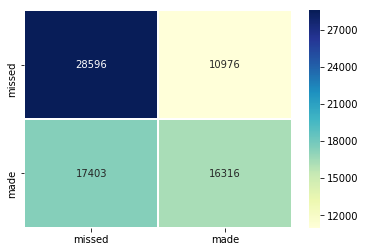

<Figure size 216x288 with 0 Axes>

######################################## TEST ########################################
Accuracy: 0.6050347932869423



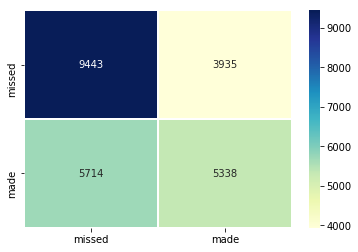

<Figure size 216x288 with 0 Axes>

######################################## VALIDATION ########################################
Accuracy: 0.6052146862592608



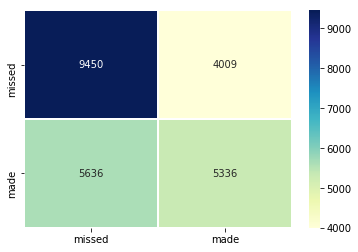

<Figure size 216x288 with 0 Axes>

In [90]:
evaluate_model(lr_model, extract_inputs, extract_outputs)

##### Conclusión Logistic Regresion

Con un accuracy de 60% con este modelo, solo estamos logrando un 10% más de predicción que arrojando una moneda en el aire.
Esto puede deberse a que nuestro conjunto de datos no es linealmente divisible.

### Gradient Boosted Trees

In [91]:
# final input columns, in the order we want to use them
train3 = train.copy()
train3 = train3.drop(['shot_result_id'],axis=1)
train3 = train3.drop(['date'],axis=1)

TREE_INPUT_COLUMNS = train3.columns.tolist() 

def tree_extract_inputs(dataset):

    # we don't want to modify the original dataset, that we will use with other models
    inputs = dataset.copy()
    
    # return the raw numbers
    return inputs[TREE_INPUT_COLUMNS].values

def tree_extract_outputs(dataset):

    return dataset.shot_result_id.values

In [92]:
from sklearn.ensemble import GradientBoostingClassifier

In [93]:
boost_model = GradientBoostingClassifier(max_depth=8)

In [94]:
boost_model.fit(
    tree_extract_inputs(train),
    tree_extract_outputs(train),
)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

######################################## TRAIN ########################################
Accuracy: 0.6866463822297417



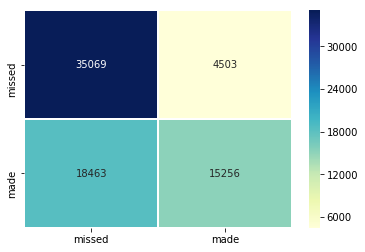

<Figure size 216x288 with 0 Axes>

######################################## TEST ########################################
Accuracy: 0.6133851821530905



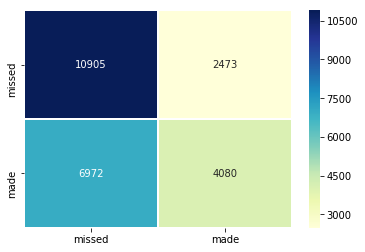

<Figure size 216x288 with 0 Axes>

######################################## VALIDATION ########################################
Accuracy: 0.6196635422209488



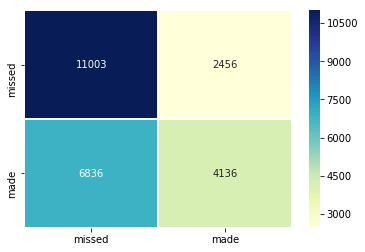

<Figure size 216x288 with 0 Axes>

In [95]:
evaluate_model(boost_model, tree_extract_inputs, tree_extract_outputs)

##### Clonclusión Gradient Boosted Trees
En test logramos un accuracy de 68%, pero en test el resultado no es el mismo y solo logramos un 61%.

No estamos superando de gran manera el accuracy logrado en el modelo anterior, por lo tanto, a resultados similares es conveniente quedarnos con Regresión logística ya que es más simple y el resultado es el mismo.

### Neural Networks

In [96]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
from keras import backend as K
import keras_metrics

Using TensorFlow backend.


In [97]:
# final input columns, in the order we want to use them
trainNN = train.copy()
trainNN = trainNN.drop(['shot_result_id'],axis=1)
trainNN = trainNN.drop(['date'],axis=1)

INPUT_COLUMNS = trainNN.columns.tolist() 


def extract_inputs(dataset):
    # we don't want to modify the original dataset, that we will use with other models
    inputs = dataset.copy()
    
    # return the raw numbers
    return inputs[INPUT_COLUMNS].values

def extract_outputs(dataset):
    return dataset.shot_result_id.values

In [98]:
nn_model = Sequential([   
    Dense(300, input_shape=(1415, )),
    Activation('tanh'),
    Dropout(0.1),
    Dense(200),
    Activation('relu'),
    Dropout(0.1),
    Dense(100),
    Activation('tanh'),
    Dense(1),
    Activation('sigmoid'),
])

nn_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [99]:
history = nn_model.fit(
    extract_inputs(train), 
    extract_outputs(train),
    epochs=500,
    batch_size=128,
    validation_data=(
        extract_inputs(test),
        extract_outputs(test),
    )
)

Instructions for updating:
Use tf.cast instead.
Train on 73291 samples, validate on 24430 samples
Epoch 1/500
73291/73291 [==============================] - 15s 203us/step - loss: 0.6923 - acc: 0.5362 - val_loss: 0.6839 - val_acc: 0.5602
Epoch 2/500
73291/73291 [==============================] - 15s 200us/step - loss: 0.6801 - acc: 0.5764 - val_loss: 0.6688 - val_acc: 0.6109
Epoch 3/500
73291/73291 [==============================] - 16s 216us/step - loss: 0.6761 - acc: 0.5870 - val_loss: 0.6878 - val_acc: 0.5670
Epoch 4/500
73291/73291 [==============================] - 16s 213us/step - loss: 0.6738 - acc: 0.5933 - val_loss: 0.6649 - val_acc: 0.6140
Epoch 5/500
73291/73291 [==============================] - 16s 213us/step - loss: 0.6717 - acc: 0.5927 - val_loss: 0.6715 - val_acc: 0.6108
Epoch 6/500
73291/73291 [==============================] - 15s 203us/step - loss: 0.6704 - acc: 0.6000 - val_loss: 0.6670 - val_acc: 0.6126
Epoch 7/500
73291/73291 [==============================] - 14s

73291/73291 [==============================] - 17s 234us/step - loss: 0.6406 - acc: 0.6292 - val_loss: 0.7258 - val_acc: 0.6012
Epoch 58/500
73291/73291 [==============================] - 14s 187us/step - loss: 0.6422 - acc: 0.6297 - val_loss: 0.7081 - val_acc: 0.6100
Epoch 59/500
73291/73291 [==============================] - 15s 202us/step - loss: 0.6403 - acc: 0.6314 - val_loss: 0.7142 - val_acc: 0.6085
Epoch 60/500
73291/73291 [==============================] - 13s 181us/step - loss: 0.6396 - acc: 0.6308 - val_loss: 0.7185 - val_acc: 0.6061
Epoch 61/500
73291/73291 [==============================] - 17s 230us/step - loss: 0.6404 - acc: 0.6270 - val_loss: 0.7078 - val_acc: 0.6131
Epoch 62/500
73291/73291 [==============================] - 16s 214us/step - loss: 0.6407 - acc: 0.6287 - val_loss: 0.7236 - val_acc: 0.6073
Epoch 63/500
73291/73291 [==============================] - 18s 247us/step - loss: 0.6390 - acc: 0.6310 - val_loss: 0.7296 - val_acc: 0.6054
Epoch 64/500
73291/73291 [

73291/73291 [==============================] - 14s 195us/step - loss: 0.6324 - acc: 0.6286 - val_loss: 0.7489 - val_acc: 0.6088
Epoch 116/500
73291/73291 [==============================] - 15s 203us/step - loss: 0.6287 - acc: 0.6349 - val_loss: 0.7509 - val_acc: 0.6102
Epoch 117/500
73291/73291 [==============================] - 16s 223us/step - loss: 0.6274 - acc: 0.6388 - val_loss: 0.7513 - val_acc: 0.6093
Epoch 118/500
73291/73291 [==============================] - 16s 212us/step - loss: 0.6272 - acc: 0.6379 - val_loss: 0.7663 - val_acc: 0.5851
Epoch 119/500
73291/73291 [==============================] - 15s 209us/step - loss: 0.6286 - acc: 0.6349 - val_loss: 0.7518 - val_acc: 0.6096
Epoch 120/500
73291/73291 [==============================] - 15s 204us/step - loss: 0.6290 - acc: 0.6343 - val_loss: 0.7506 - val_acc: 0.6090
Epoch 121/500
73291/73291 [==============================] - 15s 198us/step - loss: 0.6278 - acc: 0.6374 - val_loss: 0.7520 - val_acc: 0.6109
Epoch 122/500
73291/

73291/73291 [==============================] - 19s 255us/step - loss: 0.6228 - acc: 0.6374 - val_loss: 0.7543 - val_acc: 0.6024
Epoch 173/500
73291/73291 [==============================] - 18s 242us/step - loss: 0.6217 - acc: 0.6389 - val_loss: 0.7585 - val_acc: 0.6123
Epoch 174/500
73291/73291 [==============================] - 17s 237us/step - loss: 0.6207 - acc: 0.6428 - val_loss: 0.7461 - val_acc: 0.6093
Epoch 175/500
73291/73291 [==============================] - 18s 243us/step - loss: 0.6217 - acc: 0.6392 - val_loss: 0.7589 - val_acc: 0.6094
Epoch 176/500
73291/73291 [==============================] - 17s 238us/step - loss: 0.6199 - acc: 0.6422 - val_loss: 0.7609 - val_acc: 0.6081
Epoch 177/500
73291/73291 [==============================] - 18s 241us/step - loss: 0.6213 - acc: 0.6401 - val_loss: 0.7638 - val_acc: 0.6106
Epoch 178/500
73291/73291 [==============================] - 21s 287us/step - loss: 0.6208 - acc: 0.6410 - val_loss: 0.7590 - val_acc: 0.6114
Epoch 179/500
73291/

73291/73291 [==============================] - 16s 214us/step - loss: 0.6138 - acc: 0.6462 - val_loss: 0.7740 - val_acc: 0.6088
Epoch 230/500
73291/73291 [==============================] - 15s 209us/step - loss: 0.6139 - acc: 0.6469 - val_loss: 0.7553 - val_acc: 0.6104
Epoch 231/500
73291/73291 [==============================] - 15s 208us/step - loss: 0.6127 - acc: 0.6453 - val_loss: 0.7711 - val_acc: 0.6110
Epoch 232/500
73291/73291 [==============================] - 16s 216us/step - loss: 0.6128 - acc: 0.6470 - val_loss: 0.7651 - val_acc: 0.6096
Epoch 233/500
73291/73291 [==============================] - 16s 215us/step - loss: 0.6137 - acc: 0.6463 - val_loss: 0.7831 - val_acc: 0.6077
Epoch 234/500
73291/73291 [==============================] - 18s 242us/step - loss: 0.6136 - acc: 0.6478 - val_loss: 0.7651 - val_acc: 0.6106
Epoch 235/500
73291/73291 [==============================] - 16s 222us/step - loss: 0.6117 - acc: 0.6483 - val_loss: 0.7683 - val_acc: 0.6096
Epoch 236/500
73291/

Epoch 287/500
73291/73291 [==============================] - 17s 238us/step - loss: 0.6087 - acc: 0.6491 - val_loss: 0.7828 - val_acc: 0.6097
Epoch 288/500
73291/73291 [==============================] - 17s 226us/step - loss: 0.6069 - acc: 0.6509 - val_loss: 0.7810 - val_acc: 0.6074
Epoch 289/500
73291/73291 [==============================] - 16s 224us/step - loss: 0.6083 - acc: 0.6506 - val_loss: 0.7800 - val_acc: 0.6038
Epoch 290/500
73291/73291 [==============================] - 16s 222us/step - loss: 0.6096 - acc: 0.6469 - val_loss: 0.7831 - val_acc: 0.6094
Epoch 291/500
73291/73291 [==============================] - 17s 231us/step - loss: 0.6094 - acc: 0.6490 - val_loss: 0.7726 - val_acc: 0.6078
Epoch 292/500
73291/73291 [==============================] - 16s 219us/step - loss: 0.6085 - acc: 0.6479 - val_loss: 0.7799 - val_acc: 0.6050
Epoch 293/500
73291/73291 [==============================] - 15s 208us/step - loss: 0.6084 - acc: 0.6493 - val_loss: 0.7713 - val_acc: 0.5977
Epoch 

/home/machine/.local/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211172). Check your callbacks.
  % delta_t_median)
/home/machine/.local/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.107569). Check your callbacks.
  % delta_t_median)


73291/73291 [==============================] - 17s 236us/step - loss: 0.6100 - acc: 0.6435 - val_loss: 0.7693 - val_acc: 0.6011
Epoch 303/500
73291/73291 [==============================] - 16s 217us/step - loss: 0.6070 - acc: 0.6500 - val_loss: 0.7674 - val_acc: 0.6062
Epoch 304/500
73291/73291 [==============================] - 18s 244us/step - loss: 0.6070 - acc: 0.6491 - val_loss: 0.7728 - val_acc: 0.6099
Epoch 305/500
73291/73291 [==============================] - 16s 224us/step - loss: 0.6085 - acc: 0.6481 - val_loss: 0.7793 - val_acc: 0.6072
Epoch 306/500
73291/73291 [==============================] - 18s 240us/step - loss: 0.6062 - acc: 0.6507 - val_loss: 0.7688 - val_acc: 0.6087
Epoch 307/500
73291/73291 [==============================] - 15s 200us/step - loss: 0.6063 - acc: 0.6532 - val_loss: 0.7653 - val_acc: 0.6053
Epoch 308/500
73291/73291 [==============================] - 17s 226us/step - loss: 0.6072 - acc: 0.6515 - val_loss: 0.7767 - val_acc: 0.6099
Epoch 309/500
73291/

73291/73291 [==============================] - 13s 177us/step - loss: 0.6046 - acc: 0.6544 - val_loss: 0.7719 - val_acc: 0.6082
Epoch 360/500
73291/73291 [==============================] - 18s 242us/step - loss: 0.6050 - acc: 0.6451 - val_loss: 0.7937 - val_acc: 0.6043
Epoch 361/500
73291/73291 [==============================] - 20s 268us/step - loss: 0.6058 - acc: 0.6494 - val_loss: 0.7784 - val_acc: 0.6067
Epoch 362/500
73291/73291 [==============================] - 17s 232us/step - loss: 0.6025 - acc: 0.6531 - val_loss: 0.7887 - val_acc: 0.5941
Epoch 363/500
73291/73291 [==============================] - 15s 207us/step - loss: 0.6025 - acc: 0.6545 - val_loss: 0.7778 - val_acc: 0.6085
Epoch 364/500
73291/73291 [==============================] - 16s 212us/step - loss: 0.6025 - acc: 0.6553 - val_loss: 0.7776 - val_acc: 0.6084
Epoch 365/500
73291/73291 [==============================] - 16s 222us/step - loss: 0.6059 - acc: 0.6498 - val_loss: 0.7853 - val_acc: 0.6021
Epoch 366/500
73291/

73291/73291 [==============================] - 16s 213us/step - loss: 0.5961 - acc: 0.6595 - val_loss: 0.7921 - val_acc: 0.6069
Epoch 417/500
73291/73291 [==============================] - 17s 225us/step - loss: 0.5993 - acc: 0.6547 - val_loss: 0.7851 - val_acc: 0.6091
Epoch 418/500
73291/73291 [==============================] - 17s 231us/step - loss: 0.5987 - acc: 0.6553 - val_loss: 0.7942 - val_acc: 0.6063
Epoch 419/500
73291/73291 [==============================] - 20s 267us/step - loss: 0.6018 - acc: 0.6522 - val_loss: 0.7804 - val_acc: 0.6064
Epoch 420/500
73291/73291 [==============================] - 25s 342us/step - loss: 0.5990 - acc: 0.6569 - val_loss: 0.7768 - val_acc: 0.6068
Epoch 421/500
73291/73291 [==============================] - 19s 264us/step - loss: 0.5958 - acc: 0.6589 - val_loss: 0.8021 - val_acc: 0.6070
Epoch 422/500
73291/73291 [==============================] - 17s 238us/step - loss: 0.5972 - acc: 0.6569 - val_loss: 0.7860 - val_acc: 0.6060
Epoch 423/500
73291/

Epoch 474/500
73291/73291 [==============================] - 15s 204us/step - loss: 0.5980 - acc: 0.6556 - val_loss: 0.7841 - val_acc: 0.6029
Epoch 475/500
73291/73291 [==============================] - 15s 199us/step - loss: 0.5959 - acc: 0.6572 - val_loss: 0.7999 - val_acc: 0.6084
Epoch 476/500
73291/73291 [==============================] - 16s 217us/step - loss: 0.5954 - acc: 0.6564 - val_loss: 0.8068 - val_acc: 0.6048
Epoch 477/500
  896/73291 [..............................] - ETA: 54s - loss: 0.5804 - acc: 0.6708 

/home/machine/.local/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.504340). Check your callbacks.
  % delta_t_median)
/home/machine/.local/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254679). Check your callbacks.
  % delta_t_median)


73291/73291 [==============================] - 19s 255us/step - loss: 0.5965 - acc: 0.6565 - val_loss: 0.7977 - val_acc: 0.6025
Epoch 478/500
73291/73291 [==============================] - 15s 210us/step - loss: 0.5938 - acc: 0.6599 - val_loss: 0.7860 - val_acc: 0.6026
Epoch 479/500
73291/73291 [==============================] - 14s 193us/step - loss: 0.5937 - acc: 0.6600 - val_loss: 0.7974 - val_acc: 0.6045
Epoch 480/500
73291/73291 [==============================] - 14s 189us/step - loss: 0.5944 - acc: 0.6590 - val_loss: 0.7986 - val_acc: 0.6054
Epoch 481/500
73291/73291 [==============================] - 14s 189us/step - loss: 0.5938 - acc: 0.6589 - val_loss: 0.7911 - val_acc: 0.6062
Epoch 482/500
73291/73291 [==============================] - 15s 204us/step - loss: 0.5953 - acc: 0.6547 - val_loss: 0.7949 - val_acc: 0.6047
Epoch 483/500
73291/73291 [==============================] - 16s 217us/step - loss: 0.5971 - acc: 0.6537 - val_loss: 0.7911 - val_acc: 0.5993
Epoch 484/500
73291/

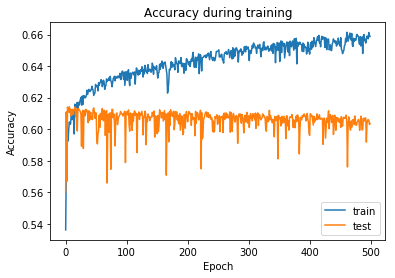

In [100]:
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('Accuracy during training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

###### Clonclusiones NN

Misma conclusión que el anterior, en test obtenemos la misma métrica que en Regresión logística, por simplicidad es mejor quedarnos con ese modelo.

A través del gráfico vemos como va overfitteando en train, porque nunca llega a superar valores en test.

# Conclusion final

Los 3 modelos que probamos logran un accuracy cercana al 61%.

Intentando diferentes variables en ningún momento logramos mejores resultados, es por esto que por simplicidad decidimos quedarnos con Regresión logística.

No superar ese valor en test puede deberse a que hay información demasiado variada dentro de nuestro dataset y para todos los modelos es muy dificil predecir esto.

Pensamos que lo ideal sería dividir a los jugadores en distintos datasets y así evaluar a cada uno individualmente, de esta forma, los datos de unos no interferirían en datos de otros y simplificaría el trabajo de los modelos. 

Nuestro error inicial, al pasarle el resultado a los modelos de forma indirecta, limitó el tiempo que teníamos en entregar el trabajo, limitando también la posibilidad de realizar algunas pruebas más. Igualmente, gracias a este error, pudimos entender el peso que tienen las variables para los modelos y como encontrar la falla a través de paciencia y análisis.